# Purpose: Viewing false positives from a previous iteration of my model which did not use differenced image preprocessing and used TF Explain to find the location of what the CNN believed to be a streak.

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
from astropy.io import fits
from astropy import wcs
import skimage
import random
import scipy.stats as stats
import pickle as pkl
from functools import partial
from multiprocessing import Pool
import cupy as cp
from cupyx.scipy.ndimage.filters import convolve
import tensorflow as tf
from tf_explain.core import GradCAM, SmoothGrad, IntegratedGradients, OcclusionSensitivity
import efficientnet.tfkeras as efn
import innvestigate
import reproject
import astroscrappy
import subprocess
import sep
from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from keras.backend.tensorflow_backend import set_session
import math
import os
from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
import urllib.request
import tables

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [2]:
# size = 80
# step = 50
# model = load_model("/home/fwang/wandb/run-20200419_062135-rljo4afi/model-best_0.0004998333888703765_0.9704852426213106_0.9609805.h5")
# thresh = 0.9609805

# size = 80
# step = 50
# model = load_model("/home/fwang/wandb/run-20200519_194207-xixqjezt/model-best_0.0005714285714285715_0.9702380952380952_0.95495033.h5")
# thresh = 0.95495033

# note: this one is size = 200
# size = 200
# step = 150
# model = load_model("/home/fwang/wandb/run-20200603_183225-wedotq6j/model-best_0.00037142857142857143_0.9706666666666667_0.9968531.h5")
# # thresh = 0.9968531
# # the threshold is way too harsh, so set it to 0.99 instead
# thresh = 0.97

# size = 150
# step = 100
# thresh = 0.97370505
# model = load_model("/home/fwang/wandb/run-20200613_185519-1fonehu2/model-best_0.0008857142857142857_0.9700952380952381_0.97370505.h5")

# size = 150
# step = 100
# thresh = 0.98012877
# model = load_model("/home/fwang/wandb/run-20200625_053040-77dw3wdm/model-best_0.0007413647851727043_0.9703664700926706_0.98012877.h5")

size = 150
step = 100
thresh = 0.95
model = load_model("/home/fwang/wandb/run-20200627_210846-bz2nhb2v/model-best_0.00045492839090143216_0.9705981465880371_0.99692285.h5")

In [5]:
fileh = tables.open_file("/mnt/etdisk9/ztf_neos/training_examples/batches/fixed_norm_no_cosmic_rays_use_psf_size150_stdx3_minlen4.h5", mode="r")

In [16]:
class PyTablesSequences(Sequence):

    def __init__(self, x_arr, y_arr, batch_size, buffer_size=2048):

        assert buffer_size % batch_size == 0

        self.x, self.y = x_arr, y_arr
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.next_load = 0

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        # print(idx)
        idx = idx * self.batch_size
        if idx >= self.next_load or idx < self.next_load - self.buffer_size:
            self.x_block = self.x[idx:idx + self.buffer_size]
            self.y_block = self.y[idx:idx + self.buffer_size]
#             indexes = np.random.permutation(len(self.x_block))
#             self.x_block = self.x_block[indexes]
#             self.y_block = self.y_block[indexes]
            self.next_load = idx + self.buffer_size

        block_index = idx - (self.next_load - self.buffer_size)
        batch_x = self.x_block[block_index:block_index + self.batch_size]
        batch_y = self.y_block[block_index:block_index + self.batch_size]

        batch_x[~np.isfinite(batch_x)] = 0

        return batch_x, batch_y

In [17]:
val_images = fileh.root.val_images
val_labels = fileh.root.val_labels
val_data = PyTablesSequences(val_images, val_labels, 256, buffer_size=1792)

In [ ]:
val_labels = []
val_predictions = []
for i in tqdm(list(range(len(val_data)))):
    batch_x, batch_y = val_data[i]
    val_labels.append(batch_y)
    val_predictions.extend(model.predict(batch_x, batch_size=len(batch_x)).flatten())

In [29]:
val_predictions = np.array(val_predictions)
val_labels = np.concatenate(val_labels)

In [32]:
indicies = np.logical_and(val_labels == 0, val_predictions > 0.9)

In [34]:
def display_triplet(pair, title=None, normalized=True):
    if not normalized:
        pair[0] = normalize(pair[0])
        pair[1] = normalize(pair[1])
    plt.figure(figsize=(10, 20))
    if title is not None:
        plt.suptitle(title)
    plt.subplot(1, 3, 1)
    plt.imshow(pair[0], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(pair[1], cmap="gray")
    plt.subplot(1, 3, 3)
    pair_input = np.transpose([pair], (0, 2, 3, 1))
    outputs, guided_grads = GradCAM.get_gradients_and_filters(model, pair_input, "conv2d_2", 0)
    cam = GradCAM.generate_ponderated_output(outputs, guided_grads)
    plt.imshow(cam[0], cmap="inferno")

In [36]:
indicies = np.where(indicies)[0]

In [38]:
hard_images = np.array([val_images[i] for i in indicies])

/opt/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


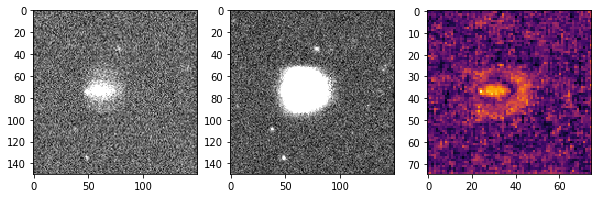

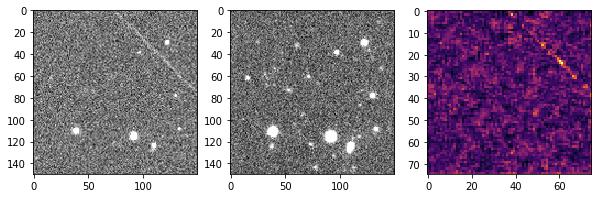

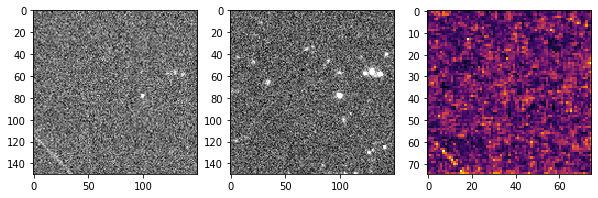

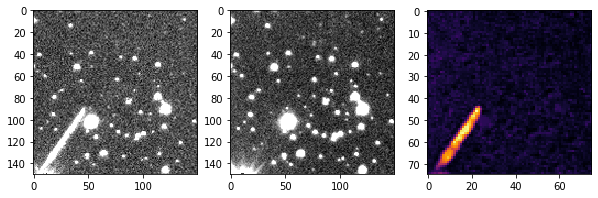

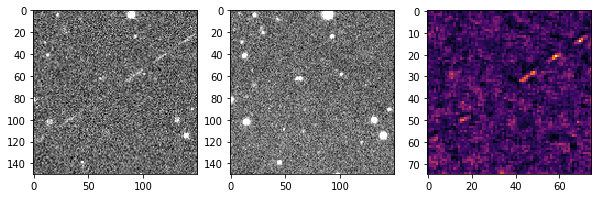

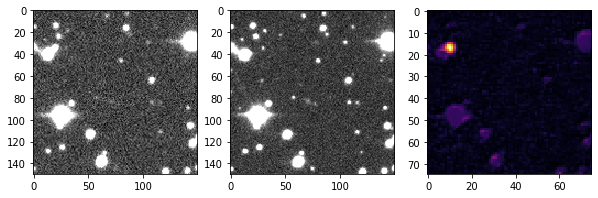

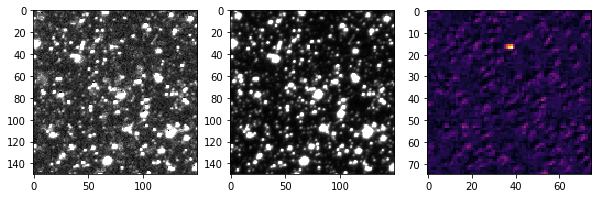

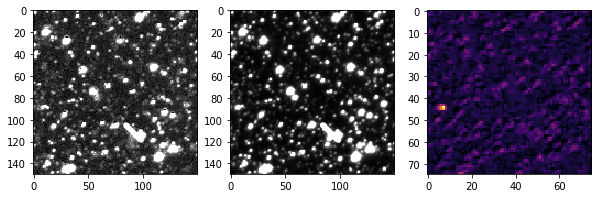

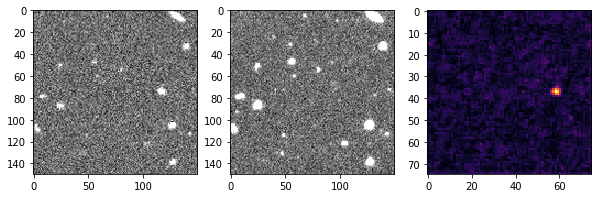

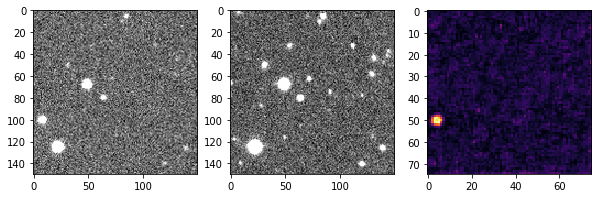

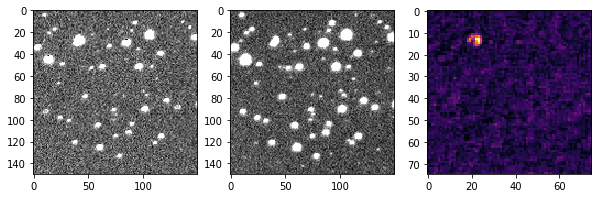

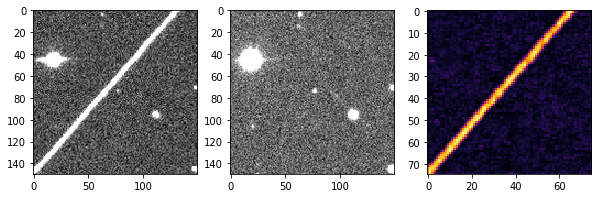

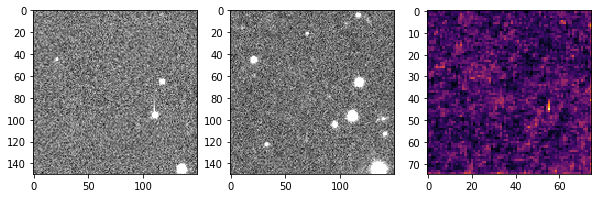

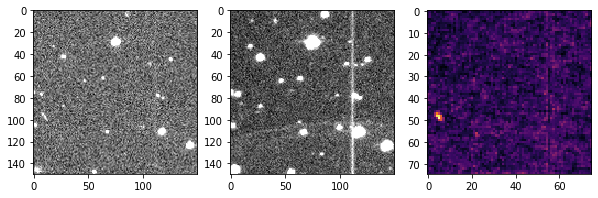

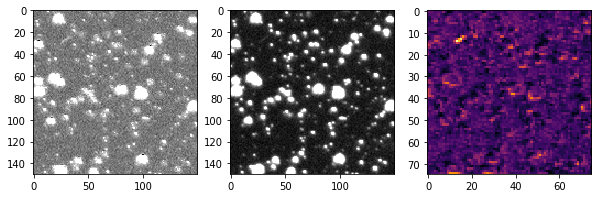

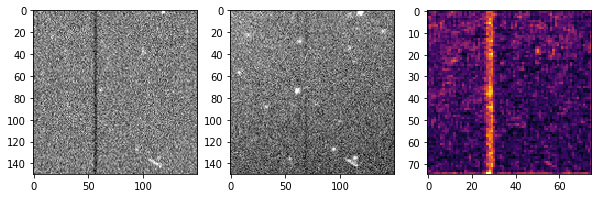

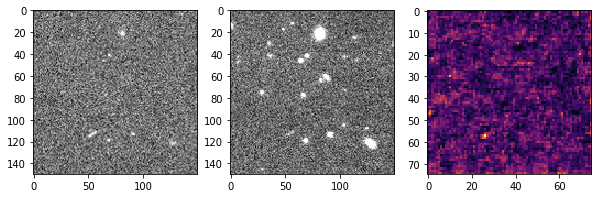

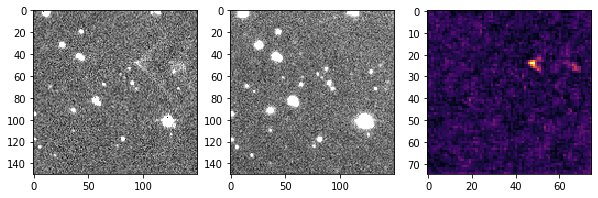

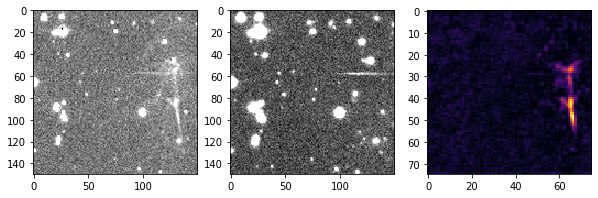

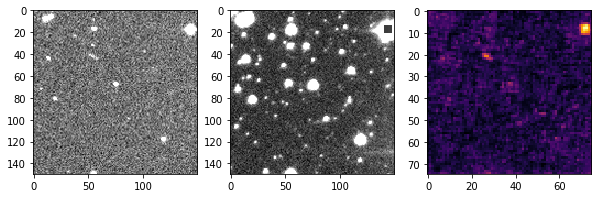

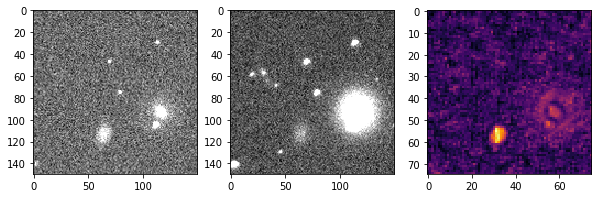

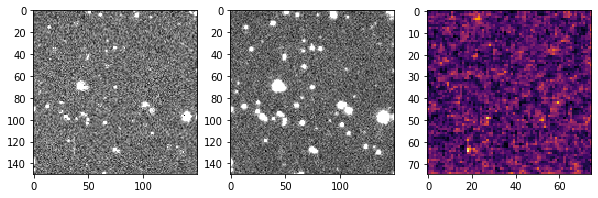

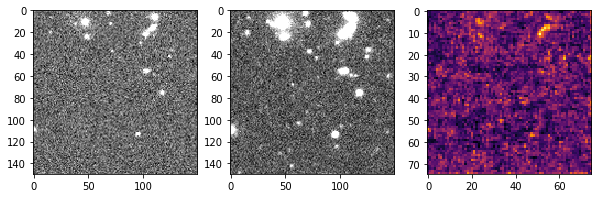

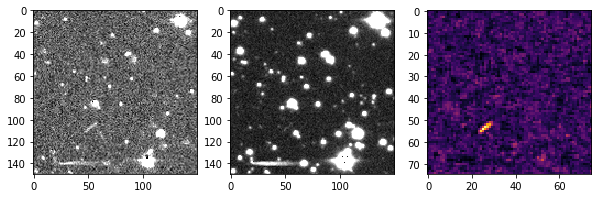

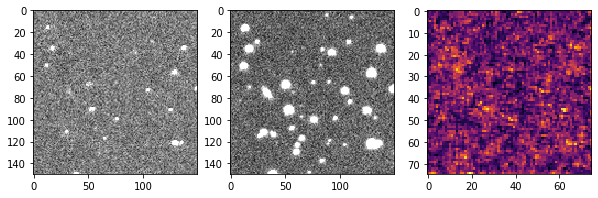

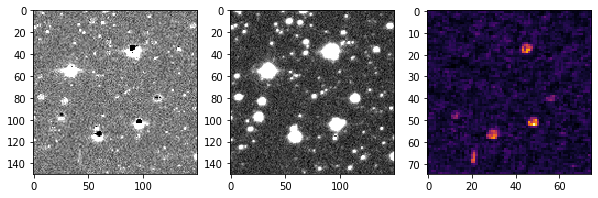

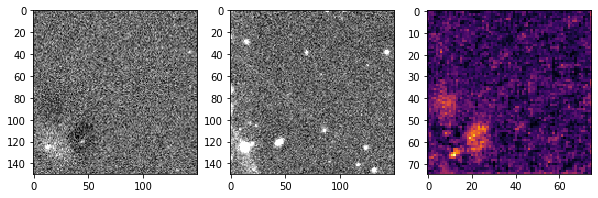

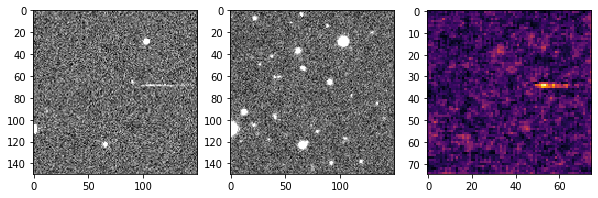

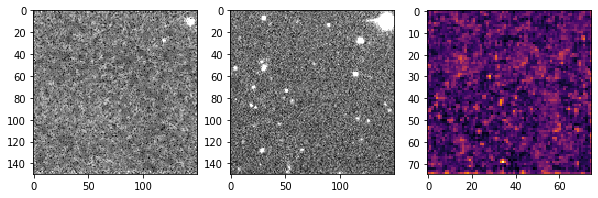

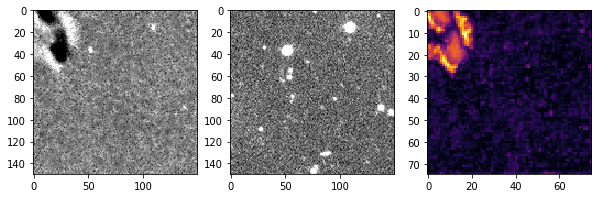

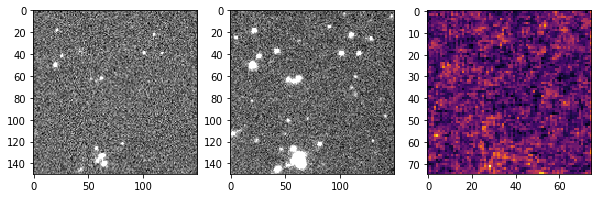

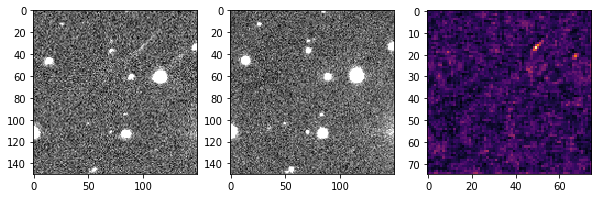

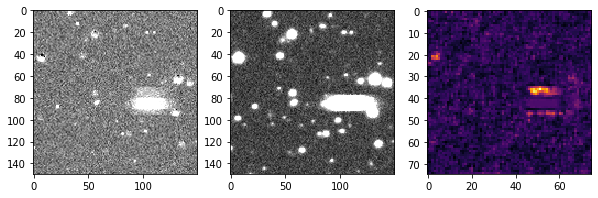

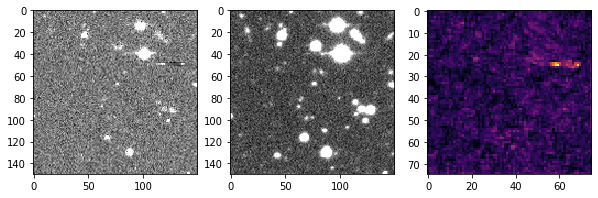

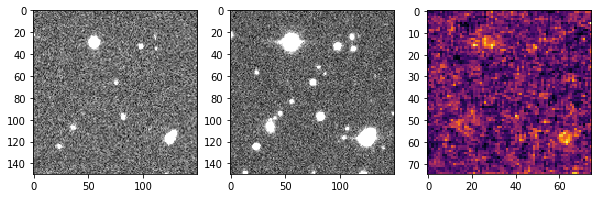

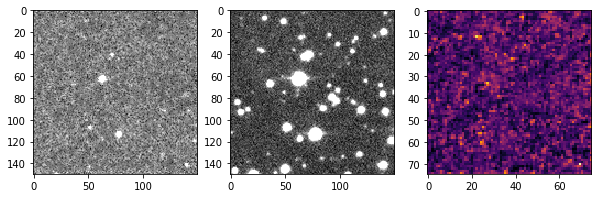

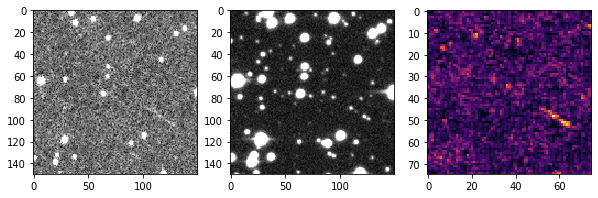

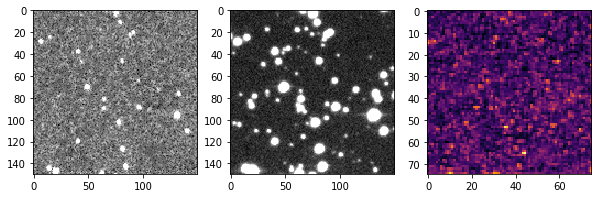

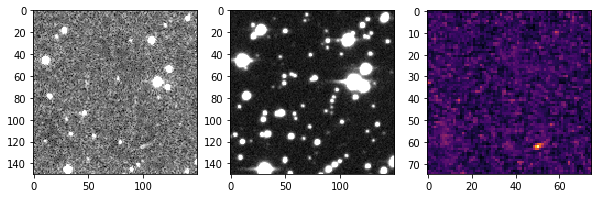

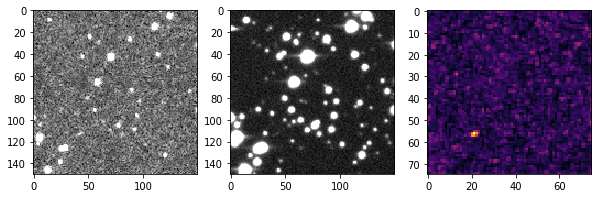

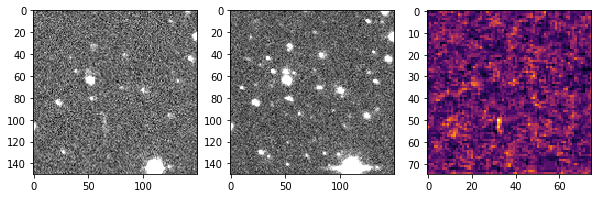

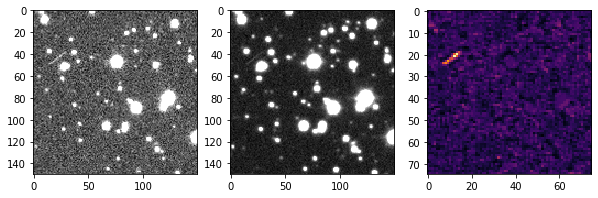

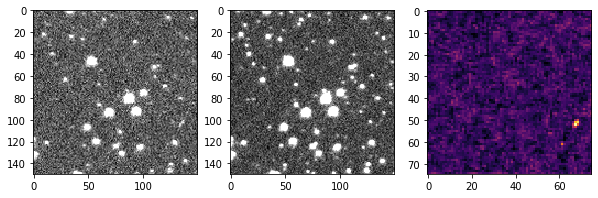

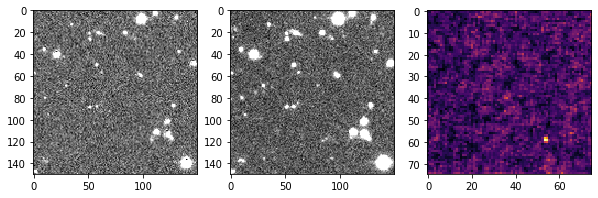

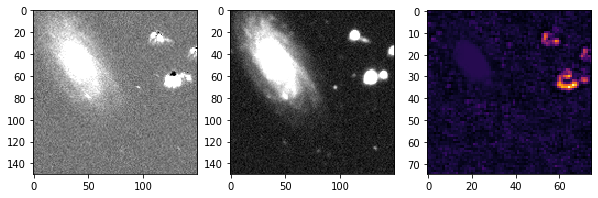

In [ ]:
for image in hard_images:
    display_triplet(np.transpose(image, (2, 0, 1)))